<a href="https://colab.research.google.com/github/hamed-javadi/hello_world/blob/master/DL_source_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Source localization with deep learning (SoLDeL)

Loading images and splitting them into training and test data

In [1]:
import numpy as np
import google.colab.drive as gd
import pickle as pkl
gd.mount('/content/gdrive',force_remount=True)
data = open('/content/gdrive/My Drive/sldb','rb')
image, y = pkl.load(data)

L, m_tot = image.shape[1], y.shape[0]
m_trn = np.floor(m_tot * .9).astype('int')
im_trn, y_trn = image[:m_trn,:,:].reshape(m_trn,L,L,1), y[:m_trn,:]
im_test, y_test = image[m_trn:,:,:].reshape(m_tot-m_trn,L,L,1), y[m_trn:,:]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dropout, Dense, Flatten

model = Sequential()
# Convolution Layer 1
model.add(Conv2D(filters=4,kernel_size=5,activation = 'relu', input_shape=(100,100,1)))
model.add(AveragePooling2D(pool_size=(4, 4)))
# Convolution Layer 2
model.add(Conv2D(filters=2,kernel_size=5,activation = 'relu'))
model.add(AveragePooling2D(pool_size=(4, 4)))

model.add(Flatten())
# FCN Layer 1
model.add(Dense(25,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='relu'))

model.summary()

# Compile CNN
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 4)         104       
_________________________________________________________________
average_pooling2d_1 (Average (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 2)         202       
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 2)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)      

In [3]:
model.fit(im_trn, y_trn, validation_data=(im_test, y_test), epochs=16, batch_size=500, verbose=1)
scores = model.evaluate(im_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

#from keras.models import load_model
model.save('/content/gdrive/My Drive/soldel_model1.h5')

Instructions for updating:
Use tf.cast instead.
Train on 351000 samples, validate on 39000 samples
Epoch 1/16
351000/351000 [==============================] - 2172s 6ms/step - loss: 1326.9003 - acc: 0.6043 - val_loss: 555.0476 - val_acc: 0.8945
Epoch 2/16
351000/351000 [==============================] - 2170s 6ms/step - loss: 1063.0956 - acc: 0.6537 - val_loss: 487.7340 - val_acc: 0.9053
Epoch 3/16
351000/351000 [==============================] - 2163s 6ms/step - loss: 1015.0391 - acc: 0.6713 - val_loss: 465.3767 - val_acc: 0.9095
Epoch 4/16
351000/351000 [==============================] - 2162s 6ms/step - loss: 979.3933 - acc: 0.6837 - val_loss: 454.7269 - val_acc: 0.9134
Epoch 5/16
351000/351000 [==============================] - 2154s 6ms/step - loss: 945.4281 - acc: 0.6886 - val_loss: 412.3117 - val_acc: 0.9145
Epoch 6/16
351000/351000 [==============================] - 2161s 6ms/step - loss: 915.0850 - acc: 0.6888 - val_loss: 423.2812 - val_acc: 0.9207
Epoch 7/16
351000/351000 [==

#Applying the model in source localization

In [0]:
#import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
#import google.colab.drive as gd
#gd.mount('/content/gdrive',force_remount=True)

#from keras.models import load_model
#model = load_model('/content/gdrive/My Drive/soldel.h5')

def network_layout(K,nodes,pfa,el,P0,sig):
  tau = chi2.ppf(1-pfa,1)
  d = np.zeros(K) #distance of nodes to the event location
  for i in range(K):
    d[i]=np.sqrt((nodes[i,0] - el[0])**2 + (nodes[i,1]-el[1])**2)
  P = P0 / (1+d**a)
  t = P > 2
  P = P * t
  
  x = np.sqrt(P) + np.random.normal(0,sig,K)
  lmda = x**2 / sig**2
  y = lmda > tau
  return y

def layout2image(L,nodes,y):
  im = np.zeros((L,L))
  i = 0
  for loc in nodes:
    nl = np.floor(loc).astype(int)
    #pdb.set_trace()
    if y[i] == True:
      im[nl[0],nl[1]] = 255
    i += 1
  return im

##MSE vs. K

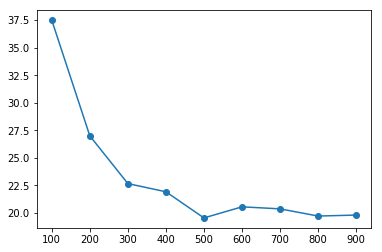

In [12]:
# Parameters
pfa = .1
P0 = 1000
a = 2      # loss coefficient in isotropic source signal model
sig = 1    # standard deviation of measurement noise of nodes
L = 100    # field size
mc_runs = 300    # Monte-Carlo runs
# Main Code
K = np.arange(100,1000,100)
mse_mc = np.zeros(mc_runs)
mse = np.zeros(len(K))
for i in range(len(K)):
  mc = 0
  while mc < mc_runs:
    nodes = L * np.random.rand(K[i],2)
    el = L * np.random.rand(2)   # event location
    y = network_layout(K[i],nodes,pfa,el,P0,sig)
    image = layout2image(L,nodes,y)
    el_hat = model.predict(image.reshape(1,L,L,1))
    mse_mc[mc] = np.linalg.norm(el-el_hat)
    mc += 1
  mse[i] = np.mean(mse_mc)

mse_K = mse
plt.figure()
plt.plot(K,mse,'-o')
plt.show()


## MSE vs. SNR

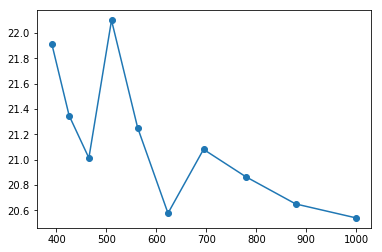

In [13]:
# Parameters
pfa = .1
P0 = 1000
a = 2      # loss coefficient in isotropic source signal model
K = 500    # standard deviation of measurement noise of nodes
L = 100    # field size
mc_runs = 1000    # Monte-Carlo runs
# Main Code
sig = np.linspace(1,1.6,10)
mse_mc = np.zeros(mc_runs)
mse = np.zeros(len(sig))
for i in range(len(sig)):
  mc = 0
  while mc < mc_runs:
    nodes = L * np.random.rand(K,2)
    el = L * np.random.rand(2)   # event location
    y = network_layout(K,nodes,pfa,el,P0,sig[i])
    image = layout2image(L,nodes,y)
    el_hat = model.predict(image.reshape(1,L,L,1))
    mse_mc[mc] = np.linalg.norm(el-el_hat)
    mc += 1
  mse[i] = np.mean(mse_mc)

  mse_snr = mse
plt.figure()
plt.plot(P0/(sig**2),mse,'-o')
plt.show()


##MSE vs. P<sub>fa</sub>

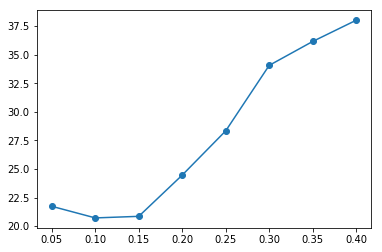

In [14]:
# Parameters
sig = 1
P0 = 1000
a = 2      # loss coefficient in isotropic source signal model
K = 500    # standard deviation of measurement noise of nodes
L = 100    # field size
mc_runs = 600    # Monte-Carlo runs
# Main Code
pfa = np.arange(.05,.45,.05)
mse_mc = np.zeros(mc_runs)
mse = np.zeros(len(pfa))
for i in range(len(pfa)):
  mc = 0
  while mc < mc_runs:
    nodes = L * np.random.rand(K,2)
    el = L * np.random.rand(2)   # event location
    y = network_layout(K,nodes,pfa[i],el,P0,sig)
    image = layout2image(L,nodes,y)
    el_hat = model.predict(image.reshape(1,L,L,1))
    mse_mc[mc] = np.linalg.norm(el-el_hat)
    mc += 1
  mse[i] = np.mean(mse_mc)
  
mse_pfa = mse  
plt.figure()
plt.plot(pfa,mse,'-o')
plt.show()

In [0]:
import pickle as pkl
res = open('/content/gdrive/My Drive/results_SoLDeL_model1','wb')
pkl.dump([mse_K, mse_snr, mse_pfa],res)
res.close()

##Tracking